In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp
import os
import sys
import pandas as pd
import sympy
import seaborn as sns
sys.path.append('../')  

import pysindy as ps
# Seed the random number generators for reproducibility
np.random.seed(100)

from test_data import *
from numpy.linalg import matrix_rank, svd
from itertools import product
from utils import plot_result_jacobi
from error_bounds import *
from matplotlib.colors import LinearSegmentedColormap
from jrc_analysis import *

#Defining colors for the plots: green = true , red = false
green=(100/255,250/255,100/255)#(0,1,0)
neutral_color = (1, 1, 1)  
red=(241/255,13/255,30/255)
cmap_green_red = LinearSegmentedColormap.from_list('RedGreen', [green,neutral_color,red], N=256)
cmap_red_green = LinearSegmentedColormap.from_list('GreenRed', [red,neutral_color,green], N=256)

In [18]:
def plot_classif_vs_noiselevel(plot_results,N):
    # Plotting
    plt.figure(figsize=(10, 6))
    # Get the unique fd_order values
    fd_orders = plot_results['fd_order'].unique()
    markers = ['s','o','x','P','*']
    # Plot each fd_order separately
    for i,fd_order in enumerate(fd_orders):
        subset = plot_results[plot_results['fd_order'] == fd_order]
        plt.plot(subset['noise_level'].values, subset['Correct_Classification'].values, marker=markers[i], label=f'FD Order {fd_order}')
    
    plt.title('Correct Classification vs Noise Level')
    plt.xlabel('Noise Level')
    plt.ylabel('Correct Classified PDEs')
    plt.xscale('log')
    plt.legend(title='FD Order')
    tick_positions = np.arange(0,N+1,1)  
    tick_labels = [f"{tick}/{N}" for tick in tick_positions]  
    plt.yticks(tick_positions, tick_labels)
    plt.grid(True)
    plt.show()

def plot_classif_vs_noiselevel_unique_nonunique(plot_results,N_unique,N_nonunique,path=None):
    labelsize=15
    titlesize=15
    f, (ax1, ax2) = plt.subplots(1, 2,figsize=(8,3))
    #plt.suptitle('Correct Classification vs Noise Level', fontsize=titlesize)
    markers = ['s','o','x','P','*']
    # Plot unique'
    fd_orders = plot_results['fd_order'].unique()
    plot_class = plot_results[plot_results['True_Class'] == "unique"]
    for i,fd_order in enumerate(fd_orders):
            N=N_unique
            subset = plot_class[plot_results['fd_order'] == fd_order]
            ax1.plot(subset['noise_level'].values, subset['Correct_Classification'].values, marker=markers[i], label=f'{fd_order:.0f}')
            ax1.set_title("Unique", fontsize=labelsize)
            ax1.set_xlabel('Noise Level', fontsize=labelsize)
            ax1.set_ylabel('Correct Classified PDEs', fontsize=labelsize)
            ax1.set_xscale('log')
            tick_positions = np.arange(0,N+1,1)  
            tick_labels = [f"{tick}/{N}" for tick in tick_positions]  
            ax1.set_yticks(tick_positions)
            ax1.set_yticklabels(tick_labels, fontsize=labelsize)
            ax1.tick_params(axis='x', labelsize=labelsize)
            ax1.tick_params(axis='y', labelsize=labelsize)
    #Plot non unique
    plot_class = plot_results[plot_results['True_Class'] == "non unique"]
    for i,fd_order in enumerate(fd_orders):
            N=N_nonunique
            subset = plot_class[plot_results['fd_order'] == fd_order]
            ax2.plot(subset['noise_level'].values, subset['Correct_Classification'].values, marker=markers[i], label=f'{fd_order:.0f}')
            ax2.set_title("Non unique", fontsize=labelsize)
            ax2.set_xlabel('Noise Level', fontsize=labelsize)
            ax2.set_xscale('log')
            ax2.legend(title='FD Order', fontsize=labelsize-2)
            tick_positions = np.arange(0,N+1,1)  
            tick_labels = [f"{tick}/{N}" for tick in tick_positions]  
            ax2.set_yticks(tick_positions) 
            ax2.set_yticklabels(tick_labels, fontsize=labelsize)
            ax2.tick_params(axis='x', labelsize=labelsize)
            ax2.tick_params(axis='y', labelsize=labelsize)
    if path!=None:
        plt.savefig(path)
    plt.show()
#plot_classif_vs_noiselevel_unique_nonunique(plot_results,N_unique,N_nonunique)

In [3]:
def perform_experiment_jrc(noise_levels,fd_order,experiment_name,true_class,C2_param=1e-3,tickssize=16):
    results = pd.DataFrame(columns = ["True_Class", "Pred_Class","C2","noise_level","fd_order"])
    #Get data,
    u,x,t,formula = experiment_data(n_samples=150,experiment_name=experiment_name)
    dx=x[1]-x[0]
    dt=t[1]-t[0]
    print(f"Performing experiment {experiment_name} {formula} with order {fd_order}, C2 = {C2_param:.2e}")
    subtitle=f"Experiment {experiment_name} {formula}, Order {fd_order}, C2_param = {C2_param:.2e}"
    T,X = np.meshgrid(t,x)
    C_upper_bounds_deriv = get_Cut_Cux_Cuxx_Cutx(formula,X,T,fd_order)
    
    for i,noise_level in enumerate(noise_levels):
        u_noise = add_noise(u,noise_level)
        eps = infinity_norm(u-u_noise)
        svs, lower_bounds,upper_bounds,space_range,time_range = get_results(u_noise,C_upper_bounds_deriv,fd_order,dt,dx,eps,C2_param)   
        upper_minus_svs = upper_bounds - svs
        lower_minus_svs = lower_bounds - svs
        
        # Find out the classifcation
        # If the Jacobian has full rank for at least one data point →PDE unique
        if ((lower_minus_svs < 0) & (upper_minus_svs < 0)).any() :
            predicted_class = "unique"
        # If the PDE is algebraic and at every data point the Jacobian does not have full rank
        # -> PDE non unique
        elif ((upper_minus_svs > 0) & (lower_minus_svs > 0)).all() :
            #print("Prediction is non unique")
            #print("upper", upper_minus_svs)
            #print("lower", lower_minus_svs)
            predicted_class = "non unique"
        else:
            #print("upper_minus", upper_minus_svs)
            #print("lower_minus", lower_minus_svs)
            predicted_class = None
        results.loc[len(results)] = [true_class, predicted_class,C2_param,noise_level,fd_order]
    results["Correct_Classification"]=results["True_Class"]==results["Pred_Class"]
    return results    

### JRC

In [4]:
experiment_names= ['algebraic_nonunique_kdv','algebraic_nonunique_1','analytic_unique_1','analytic_unique_2','analytic_nonunique_1']
dic_experiments = {'algebraic_nonunique_kdv': "non unique", # it is acutally unique if we only look at the first derivative, non unique if we look at the 3rd
                   'algebraic_nonunique_1': "non unique",
                   'analytic_unique_1': "unique",
                   'analytic_unique_2': "unique",
                   'analytic_nonunique_1': "unique"}
len_noise=10
noise_levels = [0] + [10**(i-10) for i in range(0,len_noise)]
fd_orders=[2,6,8,10,12]

In [6]:
all_results = pd.DataFrame(columns=["True_Class", "Pred_Class","C2","noise_level","fd_order","experiment"])
for experiment_name in experiment_names:
    for fd_order in fd_orders:
        true_class = dic_experiments[experiment_name]
        result_exp = perform_experiment_jrc(noise_levels,fd_order,experiment_name,true_class)
        result_exp["experiment"] = experiment_name
        all_results = pd.concat([all_results,result_exp])

Performing experiment algebraic_nonunique_kdv 0.235717581866247/cosh(0.161846370156537*t - 0.343305681475159*x)**2 with order 2, C2 = 1.00e-03
Performing experiment algebraic_nonunique_kdv 0.235717581866247/cosh(0.161846370156537*t - 0.343305681475159*x)**2 with order 6, C2 = 1.00e-03
Performing experiment algebraic_nonunique_kdv 0.235717581866247/cosh(0.161846370156537*t - 0.343305681475159*x)**2 with order 8, C2 = 1.00e-03
Performing experiment algebraic_nonunique_kdv 0.235717581866247/cosh(0.161846370156537*t - 0.343305681475159*x)**2 with order 10, C2 = 1.00e-03
Performing experiment algebraic_nonunique_kdv 0.235717581866247/cosh(0.161846370156537*t - 0.343305681475159*x)**2 with order 12, C2 = 1.00e-03
Performing experiment algebraic_nonunique_1 1/(t + x) with order 2, C2 = 1.00e-03
Performing experiment algebraic_nonunique_1 1/(t + x) with order 6, C2 = 1.00e-03
Performing experiment algebraic_nonunique_1 1/(t + x) with order 8, C2 = 1.00e-03
Performing experiment algebraic_nonun

In [7]:
all_results["Correct_Classification"]=all_results["True_Class"]==all_results["Pred_Class"]

In [26]:
all_results.to_csv("results/all_results_plots_jrc.csv")

In [27]:
all_results= pd.read_csv("results/all_results_plots_jrc.csv")

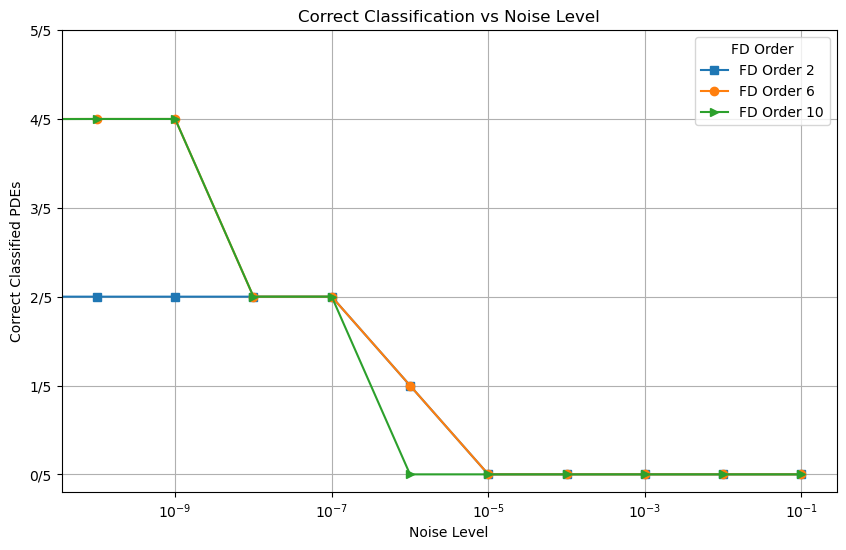

In [8]:
#Plot the number of classified equations per noise level
results_filter = all_results[all_results["fd_order"].isin([2,6,10])]
N = len(results_filter["experiment"].unique())
columns = ["noise_level","fd_order","Correct_Classification"]
plot_results = results_filter[columns].groupby(["noise_level","fd_order"]).sum().reset_index()
plot_results
plot_classif_vs_noiselevel(plot_results,N)

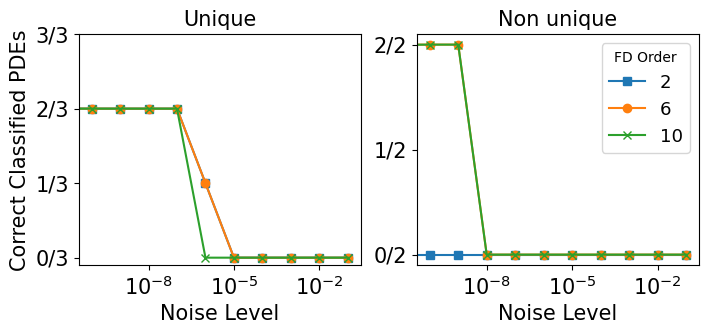

In [19]:
#Plot the number of classified equations per noise level
N_nonunique = len(results_filter[results_filter["True_Class"]=="non unique"]["experiment"].unique())
N_unique = len(results_filter[results_filter["True_Class"]=="unique"]["experiment"].unique())
columns = ["noise_level","fd_order","True_Class","Correct_Classification"]
plot_results = results_filter[columns].groupby(["noise_level","fd_order","True_Class"]).sum().reset_index()
plot_results
path = "Paper/jrc_results_analysis.png"
plot_classif_vs_noiselevel_unique_nonunique(plot_results,N_unique,N_nonunique,path)

### SFranCo

In [11]:
from sfranco_analysis import *

def perform_experiment_sfranco(noise_levels,experiment_name,true_class):
    #Get data
    u,x,t,formula = experiment_data(n_samples=150,experiment_name=experiment_name)
    dx=x[1]-x[0]
    dt=t[1]-t[0]
    print(f"Performing Experiment {experiment_name}")
    result = get_result_df(u,dx,noise_levels,orders=range(2,14,2),boundary=True)
    result.drop(["threshold_approx_nonuniq","threshold_approx_uniq"],axis=1)
    result["True_Class"]=true_class
    result['Pred_Class']=np.nan
    #if svs <= nonuniq and svs < uniq -> pde non unique
    condition = (result["ratio"] <= result["threshold_exact_nonuniq"]) & (result["ratio"] < result["threshold_exact_uniq"])
    result.loc[condition, 'Pred_Class'] = "non unique"
    # if svs >= uniq and svs > uniq -> pde unique
    condition = (result["ratio"]>=result["threshold_exact_uniq"]) & (result["ratio"]>result["threshold_exact_nonuniq"])
    result.loc[condition, 'Pred_Class'] = "unique"
    # Get if it is correctly classified
    result["Correct_Classification"]=result["True_Class"]==result["Pred_Class"]
    return result

In [12]:
experiment_names= ['linear_nonunique_1','linear_unique_1','linear_unique_1.1','linear_unique_1.2']
dic_experiments = {'linear_nonunique_1': "non unique",
                   'linear_unique_1':"unique",
                   'linear_unique_1.1': "unique",
                   'linear_unique_1.2': "unique",
                   'linear_unique_1.3': "unique"}
len_noise=10
noise_levels = [0] + [10**(i-10) for i in range(0,len_noise)]

In [14]:
%load_ext autoreload
%autoreload 2

In [16]:
all_results = pd.DataFrame(columns=["True_Class", "Pred_Class","C2","noise_level","experiment"])
for experiment_name in experiment_names:
    true_class = dic_experiments[experiment_name]
    result_exp = perform_experiment_sfranco(noise_levels,experiment_name,true_class)
    result_exp["experiment"] = experiment_name
    all_results = pd.concat([all_results,result_exp])
all_results = all_results.rename(columns={"order":"fd_order"})

Performing Experiment linear_nonunique_1
Performing Experiment linear_unique_1
Performing Experiment linear_unique_1.1
Performing Experiment linear_unique_1.2


In [17]:
all_results.to_csv("results/all_results_plots_sfranco.csv")

In [14]:
all_results= pd.read_csv("results/all_results_plots_sfranco.csv")

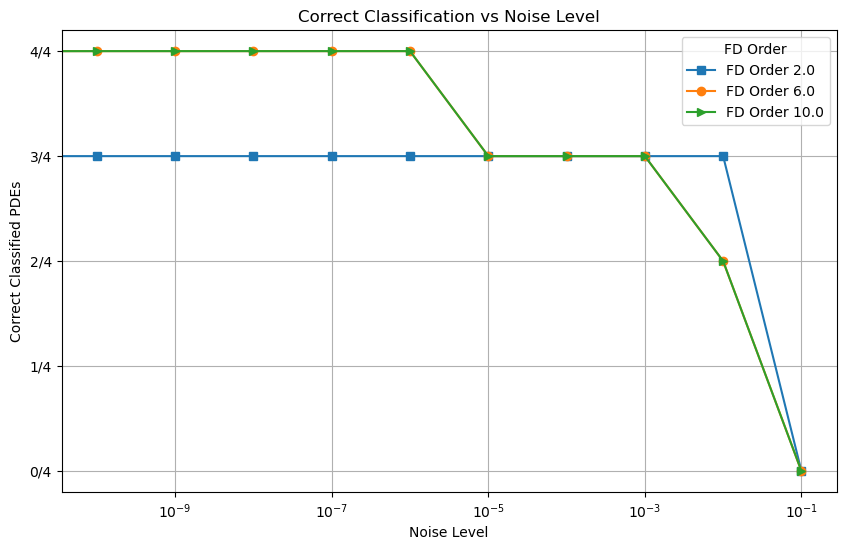

In [11]:
#Plot the number of classified equations per noise level
results_filter = all_results[all_results["fd_order"].isin([2,6,10])]
N = len(results_filter["experiment"].unique())
columns = ["noise_level","fd_order","Correct_Classification"]
plot_results = results_filter[columns].groupby(["noise_level","fd_order"]).sum().reset_index()
plot_results
plot_classif_vs_noiselevel(plot_results,N)

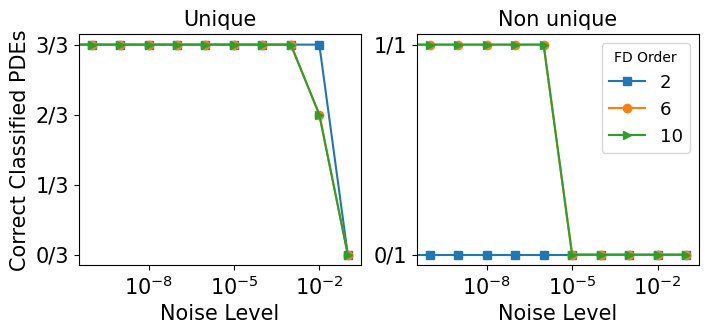

In [12]:
#Plot the number of classified equations per noise level while differentiation between unique and non unique
columns = ["noise_level","fd_order","True_Class","Correct_Classification"]
N_nonunique = len(results_filter[results_filter["True_Class"]=="non unique"]["experiment"].unique())
N_unique = len(results_filter[results_filter["True_Class"]=="unique"]["experiment"].unique())
plot_results = results_filter[columns].groupby(["noise_level","fd_order","True_Class"]).sum().reset_index()
plot_results
path = "Paper/sfranco_results_analysis.png"
plot_classif_vs_noiselevel_unique_nonunique(plot_results,N_unique,N_nonunique,path)